<a href="https://colab.research.google.com/github/markf94/SDSS2020_quantum_workshop/blob/master/solutions/solutions_tutorial_II_quantum_programming_SDSS2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Solutions for tutorial 2: Quantum programming in PyQuil

##### After going through this 1 hour tutorial you will:

- be able to use pyQuil to create shallow circuits
- have used pyQuil's wavefunction simulator
- have used pyQuil's Quantum Virtual Machine
- retrieved QPU specifications
- compiled a quantum program to the Aspen-8 QPU

### IMPORTANT!

Make sure that you are running your own local instances of the Rigetti Quantum Virtual Machine (QVM) simulator and the Quilc compiler. Check the `README.md` of this repository to find out how to do this. Otherwise this notebook won't work for you.

We need to again install pyQuil since we're now in another notebook.

In [2]:
!pip install pyquil

Looking in indexes: https://pypi.org/simple, https://pypi.proteinqure.com


***
## 1. PyQuil

PyQuil is the Python layer on top of Quil. You can think of it as a high-level abstraction layer on top of the very basic Quil instruction language. This is similar to how we use Python to program classical computers instead of writing code in low-level assembly language.


### Exercise 1.0

For our first exploration of PyQuil functionality we will use their `WavefunctionSimulator`. Please make sure to read + understand the first two paragraphs of the [documentation](http://docs.rigetti.com/en/stable/wavefunction_simulator.html#basis-ordering).

What differentiates the wavefunction simulator from other simulators and/or the QPU?

In [3]:
from pyquil.api import WavefunctionSimulator

wavefunction_simulator = WavefunctionSimulator()

#### Exercise 1.1: 
Using your knowledge from lecture II and [the pyQuil docs](http://docs.rigetti.com/en/stable/basics.html) express the following Quil code as a `Program` in PyQuil:

```
X 0
X 1
H 0
CNOT 0 1
```

Run the resulting PyQuil program 10 times with the `run_and_measure()` method of the `WavefunctionSimulator` and inspect the results.

In [4]:
from pyquil.quil import Program
from pyquil.gates import H, X, CNOT, MEASURE

# initialize a pyQuil program that measures the initial qubit state
quantum_program = Program()
quantum_program += X(0)
quantum_program += X(1)
quantum_program += H(0)
quantum_program += CNOT(0, 1)

# TODO: find out how to get the resulting wavefunction + amplitudes after running the program in the QVM
bitstrings = wavefunction_simulator.run_and_measure(quantum_program, trials=10)
print(bitstrings)

[[0 1]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]]


#### Exercise 1.2:

pyQuil's Wavefunction has a lot of very helpful functionalities like obtaining probabilities from amplitudes, plotting as well as pretty printing them. 

Explore pyQuil's wavefunction functionalities. First get the wavefunction of your new `Program` from the previous exercise, then plot and pretty print the probabilities! (Hint: there exists a not-so-well-documented `plot()` method on the `WavefunctionSimulator`)

Plotting the probabilities:


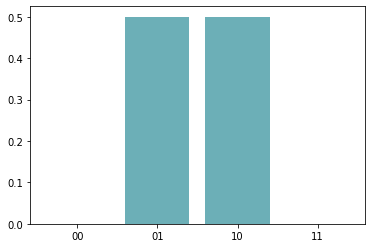

Pretty printing the wavefunction: 

(-0.71+0j)|01> + (0.71+0j)|10> 

Pretty printing the probabilities: 

{'01': 0.5, '10': 0.5}


In [7]:
%matplotlib inline
wavefunction = wavefunction_simulator.wavefunction(quantum_program)

print('Plotting the probabilities:')
wavefunction.plot()

print('Pretty printing the wavefunction: \n')
print(f'{wavefunction.pretty_print()} \n')

print('Pretty printing the probabilities: \n')
print(wavefunction.pretty_print_probabilities())

***
## 2. The Quantum Computer object

In the previous section we were using the `WavefunctionSimulator`. However, unfortunately this simulator is highly unrealistic since in reality we're never (!) able to inspect the wavefunction. We only ever get to measure the wavefunction and sample bitstrings from it. In our effort to program a quantum computer we need to abandon the idea of simulating the wavefunction and simulate the actual interaction with the quantum processor.

To do so, we're going to use the `get_qc()` method which allows us to retrieve a more realistic Quantum Virtual Machine (QVM). For our use cases, a simulator with 4 qubits should suffice:

In [8]:
from pyquil import get_qc

quantum_simulator = get_qc('2q-qvm')

#### Exercise 2.0:

Simulate your quantum program from section 1 with the new `quantum_simulator` for 10 trials. What's different?

In [12]:
bitstrings = quantum_simulator.run_and_measure(quantum_program, trials=10)
bitstrings

{0: array([0, 1, 0, 0, 1, 0, 0, 0, 1, 1]),
 1: array([1, 0, 1, 1, 0, 1, 1, 1, 0, 0])}

#### Exercise 2.1:

The output in the previous exercise was not very readable. Here's a quick way of converting the output into more familiar bitstrings:

In [13]:
import numpy as np

bitstring_array = np.vstack([bitstrings[q] for q in quantum_simulator.qubits()]).T
print(bitstring_array)

[[0 1]
 [1 0]
 [0 1]
 [0 1]
 [1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]]


Equipped with this new simulator and the function that converts its output to bitstrings perform the following experiment:

Run your quantum program for 1000 trials and compute the probability of each bitstring. Compare it with the plotted wavefunction in Exercise 1.2. What do you observe?


In [14]:
bitstrings = quantum_simulator.run_and_measure(quantum_program, trials=1000)
bitstring_array = np.vstack([bitstrings[q] for q in quantum_simulator.qubits()]).T

unique_bitstrings, counts = np.unique(bitstring_array, axis=0, return_counts=True)
for unique_bitstring, count in zip(unique_bitstrings, counts):
  unique_bitstring = np.array(map(str, unique_bitstring))
  print(f"|{''.join(unique_bitstring.tolist())}>: {count/sum(counts)}")

|01>: 0.515
|10>: 0.485


***
## 3. The Quantum Processing Unit (QPU)

Moving away from simulators this section will teach you how to interact with the Rigetti *QPU*. First, using the `list_quantum_computers()` function we can retrieve the currently available QPUs:

In [15]:
from pyquil import list_quantum_computers

print(list_quantum_computers())

['Aspen-8', 'Aspen-4', '9q-square-qvm', '9q-square-noisy-qvm']


#### Exercise 3.0:

Retrieve the topology of the `Aspen-8` QPU and plot it with `networkx.draw()`. What do you observe?

/home/markf94/.local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/markf94/.local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


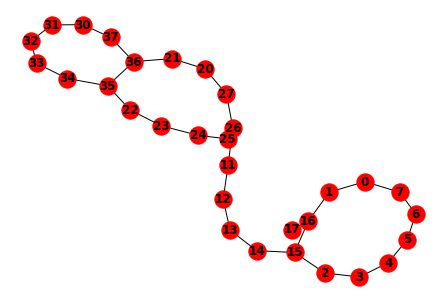

In [17]:
import networkx

aspen8 = get_qc('Aspen-8', as_qvm=True)
qpu_topology = aspen8.qubit_topology()

networkx.draw(qpu_topology, with_labels=True, font_weight='bold')

#### Exercise 3.1:

Current QPU generations are often referred to as Noisy-Intermediate Scale Quantum (NISQ) hardware. This name stems from the fact that the QPUs are suffering from quite a lot of noise and relatively low decoherence times. Try and retrieve the T1 and T2 decoherence times of the Aspen-8 chip! What's the maximum decoherence time in seconds on this chip?

In [18]:
specs = aspen8.device.get_specs()

print('Maximum T1: ', max(specs.T1s().values()))
print('Maximum T2: ', max(specs.T2s().values()))

Maximum T1:  4.49720104298557e-05
Maximum T2:  5.67804436605542e-05


***
## 4. Quantum compilation

By now you know how to write a quantum program in PyQuil and you successfully retrieved the Aspen-8 QPU. It's time to run some code on it! For the purpose of this tutorial we will have to use a simulated version of the Aspen-8 processor:

In [19]:
from pyquil.api import QVMCompiler

aspen8 = get_qc('Aspen-8', as_qvm=True)

#### Exercise 4.0:

Write the following circuit as a quantum program:


![](https://i.ibb.co/7pxPTC3/Screenshot-from-2020-06-03-00-56-51.png)

Make sure that you don't forget to measure all the qubits at the end (not included in the diagram above).

In [22]:
from pyquil.gates import Y, Z

program = Program()
ro = program.declare('ro', 'BIT', 3)
program.inst(H(0))
program.inst(H(1))
program.inst(X(2))
program.inst(H(2))
program.inst(H(1))
program.inst(Y(2))
program.inst(CNOT(1, 2))
program.inst(H(2))
program.inst(Z(0))
program.inst(H(0))
program.inst(H(1))
program.inst(X(2))
program.inst(MEASURE(0, ro[0]))
program.inst(MEASURE(1, ro[1]))
program.inst(MEASURE(2, ro[2]))

#### Exercise 4.1:

Try running your new program on the `aspen8` using the `run()` method. Carefully read the error message. What's the problem?

In [23]:
aspen8.run(program)

TypeError: `executable` argument must be a `PyQuilExecutableResponse`. Make sure you have explicitly compiled your program via `qc.compile` or `qc.compiler.native_quil_to_executable(...)` for more fine-grained control. This explicit step is required for running on a QPU.

#### Exercise 4.2:

In order to run the program on the Aspen-8 we need to first compile it to the Aspen-8 architecture. This has to do with the fact that the topology (see Exercise 3.0) might not allow certain operations e.g. CNOTs between qubits that are not neighbouring on the quantum processor.

Figure out how to compile the quantum program to the Aspen-8 architecture. Then do the following:

- print your initial non-compiled program and the compiled program. which one is longer?
- run the compiled program on the Aspen-8 simulator and retrieve 100 results

In [25]:
compiler_response = aspen8.compile(program)
print('Original quantum circuit:')
print(program)

print('Compiled quantum circuit:')
print(compiler_response.program)

# get samples
bitstrings = np.vstack([aspen8.run(compiler_response) for _ in range(100)])
unique_bitstrings, counts = np.unique(bitstrings, axis=0, return_counts=True)
for unique_bitstring, count in zip(unique_bitstrings, counts):
  unique_bitstring = np.array(map(str, unique_bitstring))
  print(f"|{''.join(unique_bitstring.tolist())}>: {count/sum(counts)}")

Original quantum circuit:
DECLARE ro BIT[3]
H 0
H 1
X 2
H 2
H 1
Y 2
CNOT 1 2
H 2
Z 0
H 0
H 1
X 2
MEASURE 0 ro[0]
MEASURE 1 ro[1]
MEASURE 2 ro[2]

Compiled quantum circuit:
DECLARE ro BIT[3]
RX(pi) 33
MEASURE 33 ro[0]
CZ 31 32
RZ(pi/2) 32
RX(pi/2) 32
RZ(pi/2) 32
MEASURE 32 ro[1]
RZ(pi) 31
RX(pi) 31
MEASURE 31 ro[2]
HALT

|101>: 0.55
|111>: 0.45


#### Bonus exercise 4.3:

Remove the measurements from the program and plot the wavefunction of the resulting quantum state. Double check your results from the QPU. Do they align?

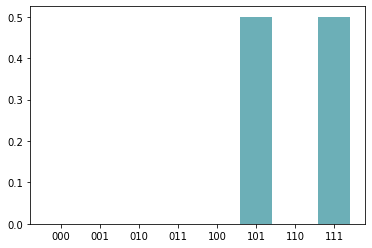

In [26]:
program_without_measurements = program.copy()
program_without_measurements.pop()
program_without_measurements.pop()
program_without_measurements.pop()

wavefunction_simulator.wavefunction(program_without_measurements).plot()

***
## 5. Bonus section: Quantum state preparation

The goal of quantum state preparation is the ability to generate quantum states with arbitrary amplitude distributions. Formally speaking, given a complex non-zero amplitude vector $\mathbf{a} \in \mathbb{C}^N$ with components $a_i$ find an algorithm that takes the initial state $\ket{0}^{\otimes \log_2 N}$ and outputs the following state:
$$\ket{\Psi} = \sum^{N-1}_{i=0} \frac{a_i}{\mid \mathbf{a} \mid} \ket{i}$$
where $\ket{i}$ stands for $i$ in its binary representation.

#### Exercise 5.0:
Design and implement a quantum circuit that initializes the following quantum state:

$$ \ket{\Psi} = \frac{-i}{2} \, \ket{00} - \frac{i}{2} \, \ket{01} + \frac{i}{2} \, \ket{10} + \frac{i}{2} \,\ket{11} $$

<a title="Use pyQuil's wavefunction functionality to print the prepared quantum state.">Hint.</a>

In [27]:
from pyquil.gates import H, Y
from pyquil.quil import Program

p = Program()

# TODO: initialize the quantum state with quantum gates
p.inst(H(0), H(1), Y(1))

print(wavefunction_simulator.wavefunction(p))

-0.5j|00> + -0.5j|01> + 0.5j|10> + 0.5j|11>


***
## 6. Bonus section: Rigetti's Grove algorithms library

There is several algorithms for quantum state preparation in the literature. For example, see [1](https://arxiv.org/pdf/1706.02721.pdf), [2](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.73.012307), [3](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.87.067901), [4](https://arxiv.org/abs/quant-ph/0208112) and [5](https://link.springer.com/article/10.1023/A:1021695125245). You should definitely read them at some point since they offer great insight into the difficulties involved with quantum state preparation. As you will see, each of these algorithms comes with it tradeoffs and you will eventually figure out which one fits your needs. Also keep in mind that near-term quantum computers limit the number of quantum gate operations you can perform due to decoherence (also called **quantum circuit depth**). Most of the above algorithms will have extensive resource requirements to ensure generality which will probably force you to do manual state preparation in order to ensure maximum efficiency.

At this point, we need to install [Grove](https://github.com/rigetticomputing/grove) - a Python library with plenty of quantum algorithms implemented in [pyQuil](https://github.com/rigetticomputing/pyquil). I highly recommend you to check out the Grove documentation since it is a great resource to learn about the individual quantum algorithms and their implementations!

In [28]:
!pip install git+https://github.com/rigetticomputing/grove

Looking in indexes: https://pypi.org/simple, https://pypi.proteinqure.com
  Cloning https://github.com/rigetticomputing/grove to /tmp/pip-req-build-klbogswn
  Running command git clone -q https://github.com/rigetticomputing/grove /tmp/pip-req-build-klbogswn
  Stored in directory: /tmp/pip-ephem-wheel-cache-hxghpwce/wheels/c4/4c/d0/aeba3b8fa052232bed7758ab80e74ec5252bd339c7ae5f8111
Successfully built quantum-grove
  Found existing installation: quantum-grove 1.7.0
    Uninstalling quantum-grove-1.7.0:
ERROR: Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/usr/local/lib/python3.7/site-packages/quantum_grove-1.7.0-py3.7.egg'
Consider using the `--user` option or check the permissions.



#### Exercise 6.0:
Use Grove's arbitrary state generation algorithm to generate the circuit for the quantum state in Exercise 5.0!

In [29]:
# TODO: Use Grove to generate circuits
from grove.alpha.arbitrary_state.arbitrary_state import create_arbitrary_state

# generating circuit for quantum state from exercise 3.0
amplitude_vector = [-1j/2, -1j/2, 1j/2, 1j/2]
p = create_arbitrary_state(amplitude_vector)
print(f'Generated wavefunction for exercise 3.0: \n{wavefunction_simulator.wavefunction(p)} \n')
print(f'Quantum circuit used to generate the state: \n{p}')

Generated wavefunction for exercise 3.0: 
-0.5j|00> + -0.5j|01> + 0.5j|10> + 0.5j|11> 

Quantum circuit used to generate the state: 
RZ(0) 0
PHASE(0) 0
H 0
H 1
RZ(pi) 0
SWAP 0 1
CNOT 1 0
CNOT 1 0
CNOT 1 0
CNOT 1 0



#### Exercise 6.1:
Print the generated circuit in Exercise 6.0 and compare it with the circuit that you designed by hand in exercise 5.0. Were you doing better or worse in terms of quantum circuit depth?